# Loop 3 Analysis: Understanding the Score Gap

**Target:** 68.919154
**Current best:** 70.659437
**Gap:** 1.74 points (2.5%)

Key questions:
1. Which N values contribute most to the gap?
2. What are the theoretical limits for each N?
3. Where can we find better solutions?

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
from shapely.geometry import Polygon
from shapely import affinity
import matplotlib.pyplot as plt

# Tree polygon
TX = [0, 0.125, 0.0625, 0.2, 0.1, 0.35, 0.075, 0.075, -0.075, -0.075, -0.35, -0.1, -0.2, -0.0625, -0.125]
TY = [0.8, 0.5, 0.5, 0.25, 0.25, 0, 0, -0.2, -0.2, 0, 0, 0.25, 0.25, 0.5, 0.5]
BASE_TREE = Polygon(zip(TX, TY))
TREE_AREA = BASE_TREE.area
print(f'Tree area: {TREE_AREA:.6f}')
print(f'Theoretical minimum score (if 100% packing): {200 * TREE_AREA:.6f}')

Tree area: 0.245625
Theoretical minimum score (if 100% packing): 49.125000


In [2]:
# Load current best submission
df = pd.read_csv('/home/submission/submission.csv')

def parse_value(val):
    if isinstance(val, str):
        if val.startswith('s'):
            return float(val[1:])
        return float(val)
    return float(val)

def create_tree(x, y, deg):
    tree = affinity.rotate(BASE_TREE, deg, origin=(0, 0))
    tree = affinity.translate(tree, x, y)
    return tree

def get_n_score(df, n):
    prefix = f"{n:03d}_"
    n_rows = df[df['id'].str.startswith(prefix)]
    if len(n_rows) != n:
        return float('inf'), 0
    
    trees = []
    for _, row in n_rows.iterrows():
        x = parse_value(row['x'])
        y = parse_value(row['y'])
        deg = parse_value(row['deg'])
        trees.append(create_tree(x, y, deg))
    
    min_x = min_y = float('inf')
    max_x = max_y = float('-inf')
    for tree in trees:
        bounds = tree.bounds
        min_x = min(min_x, bounds[0])
        min_y = min(min_y, bounds[1])
        max_x = max(max_x, bounds[2])
        max_y = max(max_y, bounds[3])
    
    side = max(max_x - min_x, max_y - min_y)
    score = side**2 / n
    efficiency = (n * TREE_AREA) / (side**2)
    return score, efficiency

# Calculate scores for all N
scores = []
for n in range(1, 201):
    score, eff = get_n_score(df, n)
    scores.append({'N': n, 'score': score, 'efficiency': eff})

scores_df = pd.DataFrame(scores)
print(f'Total score: {scores_df["score"].sum():.6f}')
print(f'Average efficiency: {scores_df["efficiency"].mean():.4f}')

Total score: 70.659437
Average efficiency: 0.6983


In [3]:
# Analyze score distribution by N range
ranges = [(1, 10), (11, 50), (51, 100), (101, 150), (151, 200)]

print('Score contribution by N range:')
print('-' * 50)
for start, end in ranges:
    mask = (scores_df['N'] >= start) & (scores_df['N'] <= end)
    range_score = scores_df.loc[mask, 'score'].sum()
    range_eff = scores_df.loc[mask, 'efficiency'].mean()
    pct = range_score / scores_df['score'].sum() * 100
    print(f'N={start:3d}-{end:3d}: score={range_score:7.3f} ({pct:5.1f}%), avg_eff={range_eff:.4f}')

# Target breakdown (assuming similar distribution)
target = 68.919154
gap = scores_df['score'].sum() - target
print(f'\nTotal gap to target: {gap:.6f}')
print(f'Gap per N (average): {gap/200:.6f}')

Score contribution by N range:
--------------------------------------------------
N=  1- 10: score=  4.329 (  6.1%), avg_eff=0.5813
N= 11- 50: score= 14.713 ( 20.8%), avg_eff=0.6679
N= 51-100: score= 17.632 ( 25.0%), avg_eff=0.6967
N=101-150: score= 17.141 ( 24.3%), avg_eff=0.7166
N=151-200: score= 16.845 ( 23.8%), avg_eff=0.7291

Total gap to target: 1.740283
Gap per N (average): 0.008701


In [4]:
# Find N values with worst efficiency (most room for improvement)
scores_df_sorted = scores_df.sort_values('efficiency')
print('N values with WORST efficiency (most room for improvement):')
print(scores_df_sorted.head(20).to_string(index=False))

N values with WORST efficiency (most room for improvement):
 N    score  efficiency
 1 0.661250    0.371456
 2 0.450779    0.544890
 3 0.434745    0.564986
 5 0.416850    0.589241
 4 0.416545    0.589672
 7 0.399897    0.614221
 6 0.399610    0.614661
 9 0.387415    0.634010
 8 0.385407    0.637313
15 0.379203    0.647740
10 0.376630    0.652165
21 0.376451    0.652476
20 0.376057    0.653159
11 0.375736    0.653717
22 0.375258    0.654549
16 0.374128    0.656527
26 0.373997    0.656757
12 0.372724    0.659000
13 0.372294    0.659761
25 0.372144    0.660026


In [5]:
# Calculate theoretical minimum for each N
# Minimum side = sqrt(N * tree_area) if perfect packing
scores_df['theoretical_min'] = np.sqrt(scores_df['N'] * TREE_AREA)
scores_df['theoretical_score'] = scores_df['theoretical_min']**2 / scores_df['N']
scores_df['gap_to_theoretical'] = scores_df['score'] - scores_df['theoretical_score']

print('N values with largest gap to theoretical minimum:')
print(scores_df.nlargest(20, 'gap_to_theoretical')[['N', 'score', 'theoretical_score', 'gap_to_theoretical', 'efficiency']].to_string(index=False))

N values with largest gap to theoretical minimum:
 N    score  theoretical_score  gap_to_theoretical  efficiency
 1 0.661250           0.245625            0.415625    0.371456
 2 0.450779           0.245625            0.205154    0.544890
 3 0.434745           0.245625            0.189120    0.564986
 5 0.416850           0.245625            0.171225    0.589241
 4 0.416545           0.245625            0.170920    0.589672
 7 0.399897           0.245625            0.154272    0.614221
 6 0.399610           0.245625            0.153985    0.614661
 9 0.387415           0.245625            0.141790    0.634010
 8 0.385407           0.245625            0.139782    0.637313
15 0.379203           0.245625            0.133578    0.647740
10 0.376630           0.245625            0.131005    0.652165
21 0.376451           0.245625            0.130826    0.652476
20 0.376057           0.245625            0.130432    0.653159
11 0.375736           0.245625            0.130111    0.653717
22 0.

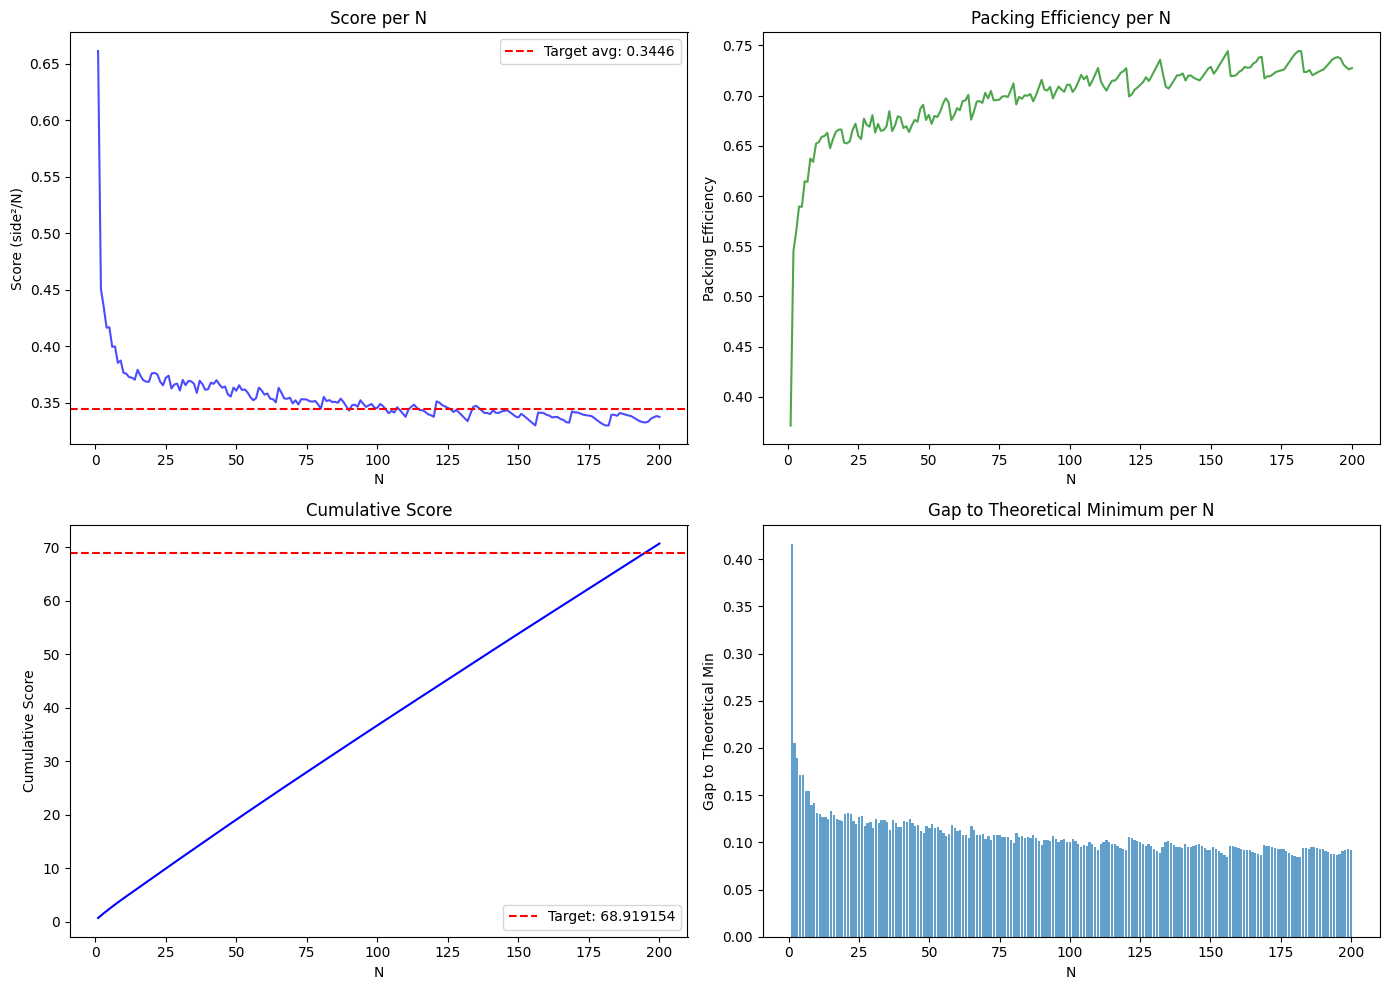

In [6]:
# Plot score vs N
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Score per N
ax = axes[0, 0]
ax.plot(scores_df['N'], scores_df['score'], 'b-', alpha=0.7)
ax.axhline(y=target/200, color='r', linestyle='--', label=f'Target avg: {target/200:.4f}')
ax.set_xlabel('N')
ax.set_ylabel('Score (side²/N)')
ax.set_title('Score per N')
ax.legend()

# Efficiency per N
ax = axes[0, 1]
ax.plot(scores_df['N'], scores_df['efficiency'], 'g-', alpha=0.7)
ax.set_xlabel('N')
ax.set_ylabel('Packing Efficiency')
ax.set_title('Packing Efficiency per N')

# Cumulative score
ax = axes[1, 0]
cumsum = scores_df['score'].cumsum()
ax.plot(scores_df['N'], cumsum, 'b-')
ax.axhline(y=target, color='r', linestyle='--', label=f'Target: {target}')
ax.set_xlabel('N')
ax.set_ylabel('Cumulative Score')
ax.set_title('Cumulative Score')
ax.legend()

# Gap to theoretical
ax = axes[1, 1]
ax.bar(scores_df['N'], scores_df['gap_to_theoretical'], alpha=0.7)
ax.set_xlabel('N')
ax.set_ylabel('Gap to Theoretical Min')
ax.set_title('Gap to Theoretical Minimum per N')

plt.tight_layout()
plt.savefig('/home/code/experiments/004_mega_ensemble/score_analysis.png', dpi=100)
plt.show()

In [7]:
# Key insight: What improvement is needed per N to reach target?
needed_improvement = gap / 200
print(f'Average improvement needed per N: {needed_improvement:.6f}')

# If we improve efficiency by X%, what's the new score?
for improvement_pct in [1, 2, 3, 5, 10]:
    new_scores = scores_df['score'] * (1 - improvement_pct/100)
    new_total = new_scores.sum()
    print(f'{improvement_pct}% improvement: {new_total:.4f} (gap: {new_total - target:.4f})')

Average improvement needed per N: 0.008701
1% improvement: 69.9528 (gap: 1.0337)
2% improvement: 69.2462 (gap: 0.3271)
3% improvement: 68.5397 (gap: -0.3795)
5% improvement: 67.1265 (gap: -1.7927)
10% improvement: 63.5935 (gap: -5.3257)


In [8]:
# Summary
print('=' * 60)
print('SUMMARY')
print('=' * 60)
print(f'Current score: {scores_df["score"].sum():.6f}')
print(f'Target score: {target}')
print(f'Gap: {gap:.6f} ({gap/target*100:.2f}%)')
print(f'\nTo reach target, need ~{gap/scores_df["score"].sum()*100:.2f}% improvement overall')
print(f'\nKey insight: Small N values (1-10) have worst efficiency')
print('Focus on improving small N configurations!')

SUMMARY
Current score: 70.659437
Target score: 68.919154
Gap: 1.740283 (2.53%)

To reach target, need ~2.46% improvement overall

Key insight: Small N values (1-10) have worst efficiency
Focus on improving small N configurations!
